In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 582.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 873.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 393.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphNorm
from torch_geometric.loader import DataLoader

# ======= Step 1: Load & Process Data =======
file_path = "/content/dataset_2years (1).csv"  # Replace with actual file path
df = pd.read_csv(file_path)

# Handle missing values
df.fillna(0, inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
df["Payment Method"] = label_encoder.fit_transform(df["Payment Method"])
df["DayOfWeek"] = label_encoder.fit_transform(df["DayOfWeek"])
df["Transaction Type"] = df["Transaction Type"].map({"Income": 1, "Expense": 0})

# Create "Amount" column (Income + Expense)
df["Amount"] = df["Income"] + df["Expense"]

# Normalize values
scaler = MinMaxScaler()
df[["Income", "Expense", "Amount", "Balance"]] = scaler.fit_transform(df[["Income", "Expense", "Amount", "Balance"]])

# Create node features
node_features = torch.tensor(df[["Income", "Expense", "Amount", "Transaction Type", "Payment Method", "DayOfWeek", "Balance"]].values, dtype=torch.float)

# ======= Step 2: Graph Creation =======
edges = []
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if df.iloc[i]["Category"] == df.iloc[j]["Category"] or df.iloc[i]["Payment Method"] == df.iloc[j]["Payment Method"]:
            edges.append((i, j))
            edges.append((j, i))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Graph Data
data = Data(x=node_features, edge_index=edge_index)

# ======= Step 3: Transformer-Based Anomaly Detector =======
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, ff_dim=128):
        super(TransformerEncoder, self).__init__()

        # Ensure num_heads is a divisor of input_dim
        num_heads = max([h for h in range(1, input_dim + 1) if input_dim % h == 0 and h <= 8])

        self.self_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.ff = nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, input_dim)
        )

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.ff(x))
        return x


# ======= Step 4: Diffusion-Based Noise Learning =======
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DiffusionModel, self).__init__()
        self.denoiser = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, noise_level=0.1):
        noise = torch.randn_like(x) * noise_level
        return self.denoiser(x + noise)

# ======= Step 5: Initialize Models & Optimizer =======
transformer = TransformerEncoder(input_dim=node_features.shape[1])
diffusion = DiffusionModel(input_dim=node_features.shape[1], hidden_dim=32)

optimizer = torch.optim.Adam(list(transformer.parameters()) + list(diffusion.parameters()), lr=0.001)

# ======= Step 6: Train the Model =======
def train():
    transformer.train()
    diffusion.train()

    optimizer.zero_grad()

    embeddings = transformer(data.x.unsqueeze(0)).squeeze(0)  # Transformer expects batch
    reconstructed = diffusion(embeddings)

    loss = F.mse_loss(reconstructed, embeddings)  # Learn normal transaction patterns
    loss.backward()
    optimizer.step()

    return loss.item()

best_loss = float("inf")
patience, counter = 10, 0

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

    if loss < best_loss:
        best_loss = loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered!")
        break

# ======= Step 7: Anomaly Detection =======
transformer.eval()
diffusion.eval()

with torch.no_grad():
    embeddings = transformer(data.x.unsqueeze(0)).squeeze(0)
    reconstructed = diffusion(embeddings)
    anomaly_scores = torch.mean((embeddings - reconstructed) ** 2, dim=1).numpy()

# Threshold (Top 5% Anomalies)
threshold = np.percentile(anomaly_scores, 95)
df["Anomaly Score"] = anomaly_scores
df["Anomaly"] = df["Anomaly Score"] > threshold  # Top 5% as anomalies

# ======= Step 8: Performance Metrics =======
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_true = df["Anomaly"].astype(int).values
y_pred = (df["Anomaly Score"] > threshold).astype(int)

precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
auc_roc = roc_auc_score(y_true, y_pred)

# Print results
print(f"\n🔹 **Performance Metrics**")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc_roc:.4f}")

# Save results
df.to_csv("T-Diff_anomaly_results.csv", index=False)
print("✅ Anomaly Detection Complete. Results saved to 'T-Diff_anomaly_results.csv'.")
print(df[df["Anomaly"] == True][["Date", "Category", "Expense", "Anomaly Score"]])  # Show anomalies


Epoch 0: Loss = 1.0120
Epoch 10: Loss = 0.6405
Epoch 20: Loss = 0.3967
Epoch 30: Loss = 0.2227
Epoch 40: Loss = 0.1009
Epoch 50: Loss = 0.0315
Epoch 60: Loss = 0.0099
Epoch 70: Loss = 0.0078
Epoch 80: Loss = 0.0053
Epoch 90: Loss = 0.0036

🔹 **Performance Metrics**
✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1-Score: 1.0000
✅ AUC-ROC: 1.0000
✅ Anomaly Detection Complete. Results saved to 'T-Diff_anomaly_results.csv'.
           Date               Category   Expense  Anomaly Score
0    01-01-2022                 Salary  0.000000       0.012039
1    04-01-2022              Insurance  0.272727       0.012740
33   31-01-2022                   Rent  1.000000       0.010012
69   28-02-2022          Home Loan EMI  0.806818       0.013314
108  01-04-2022                 Salary  0.000000       0.021496
143  01-05-2022                 Salary  0.000000       0.010210
147  04-05-2022                   Rent  1.000000       0.013460
182  03-06-2022                   Rent  1.000000       0.028457
214  01

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.mixture import GaussianMixture
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphNorm

# ======= Load & Process Data =======
file_path = "/content/dataset_2years (1).csv"
df = pd.read_csv(file_path)
df.fillna(0, inplace=True)

label_encoder = LabelEncoder()
df["Category"] = label_encoder.fit_transform(df["Category"])
df["Payment Method"] = label_encoder.fit_transform(df["Payment Method"])
df["DayOfWeek"] = label_encoder.fit_transform(df["DayOfWeek"])
df["Transaction Type"] = df["Transaction Type"].map({"Income": 1, "Expense": 0})
df["Amount"] = df["Income"] + df["Expense"]

scaler = MinMaxScaler()
df[["Income", "Expense", "Amount", "Balance"]] = scaler.fit_transform(df[["Income", "Expense", "Amount", "Balance"]])

node_features = torch.tensor(df[["Income", "Expense", "Amount", "Transaction Type", "Payment Method", "DayOfWeek", "Balance"]].values, dtype=torch.float)

# ======= Graph Creation =======
edges = [(i, j) for i in range(len(df)) for j in range(i+1, len(df))
         if df.iloc[i]["Category"] == df.iloc[j]["Category"] or df.iloc[i]["Payment Method"] == df.iloc[j]["Payment Method"]]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data = Data(x=node_features, edge_index=edge_index)

# ======= Transformer-Based Anomaly Detector =======
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, ff_dim=128, dropout=0.1):
        super().__init__()
        num_heads = max([h for h in range(1, input_dim + 1) if input_dim % h == 0 and h <= 8])
        self.self_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, input_dim)
        )

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x + self.dropout(self.ff(x)))
        return x

# ======= Diffusion-Based Noise Learning =======
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.denoiser = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x, noise_level=0.1):
        noise = torch.randn_like(x) * noise_level
        return self.denoiser(x + noise)

# ======= Initialize Models & Optimizer =======
gcn = GCNConv(node_features.shape[1], node_features.shape[1])
transformer = TransformerEncoder(input_dim=node_features.shape[1])
diffusion = DiffusionModel(input_dim=node_features.shape[1])

optimizer = torch.optim.Adam(
    list(gcn.parameters()) + list(transformer.parameters()) + list(diffusion.parameters()),
    lr=0.001, weight_decay=1e-4
)

# ======= Training Loop =======
def train():
    gcn.train()
    transformer.train()
    diffusion.train()
    optimizer.zero_grad()

    gcn_embeddings = gcn(data.x, data.edge_index)
    embeddings = transformer(gcn_embeddings.unsqueeze(0)).squeeze(0)
    reconstructed = diffusion(embeddings)
    loss = F.mse_loss(reconstructed, embeddings)
    loss.backward()
    optimizer.step()
    return loss.item()

best_loss, patience, counter = float("inf"), 10, 0
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")
    if loss < best_loss:
        best_loss, counter = loss, 0
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered!")
        break

# ======= Anomaly Detection =======
gcn.eval()
transformer.eval()
diffusion.eval()

with torch.no_grad():
    gcn_embeddings = gcn(data.x, data.edge_index)
    embeddings = transformer(gcn_embeddings.unsqueeze(0)).squeeze(0)
    reconstructed = diffusion(embeddings)
    anomaly_scores = torch.mean((embeddings - reconstructed) ** 2, dim=1).numpy()

# ======= Improved Anomaly Thresholding with GMM =======
gmm = GaussianMixture(n_components=2, random_state=42).fit(anomaly_scores.reshape(-1, 1))
thresh = gmm.means_.max()
df["Anomaly Score"] = anomaly_scores
df["Anomaly"] = df["Anomaly Score"] > thresh

# ======= Performance Metrics =======
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
y_true = df["Anomaly"].astype(int).values
y_pred = (df["Anomaly Score"] > thresh).astype(int)

precision, recall, f1, auc_roc = (
    precision_score(y_true, y_pred, zero_division=1),
    recall_score(y_true, y_pred, zero_division=1),
    f1_score(y_true, y_pred, zero_division=1),
    roc_auc_score(y_true, y_pred)
)

print(f"\n🔹 **Performance Metrics**")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc_roc:.4f}")

df.to_csv("T-Diff_anomaly_results.csv", index=False)
print("✅ Anomaly Detection Complete. Results saved to 'T-Diff_anomaly_results.csv'.")
print(df[df["Anomaly"] == True][["Date", "Category", "Expense", "Anomaly Score"]])

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Epoch 0: Loss = 1.1755
Epoch 10: Loss = 0.8635
Epoch 20: Loss = 0.5521
Epoch 30: Loss = 0.3632
Epoch 40: Loss = 0.2109
Epoch 50: Loss = 0.1149
Epoch 60: Loss = 0.0655
Epoch 70: Loss = 0.0452
Epoch 80: Loss = 0.0360
Epoch 90: Loss = 0.0303

🔹 **Performance Metrics**
✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1-Score: 1.0000
✅ AUC-ROC: 1.0000
✅ Anomaly Detection Complete. Results saved to 'T-Diff_anomaly_results.csv'.
           Date  Category   Expense  Anomaly Score
0    01-01-2022        25  0.000000       0.018898
3    04-01-2022        14  0.806818       0.011497
46   04-02-2022        10  0.329545       0.009646
106  31-03-2022        10  0.329545       0.008639
120  10-04-2022        29  0.068182       0.011647
193  13-06-2022        29  0.068182       0.014464
324  05-10-2022        20  0.034091       0.010690
327  07-10-2022         5  0.272727       0.009953
340  18-10-2022         8  0.534091       0.009802
407  12-12-2022        11  0.056818       0.012044
416  16-12-2022       

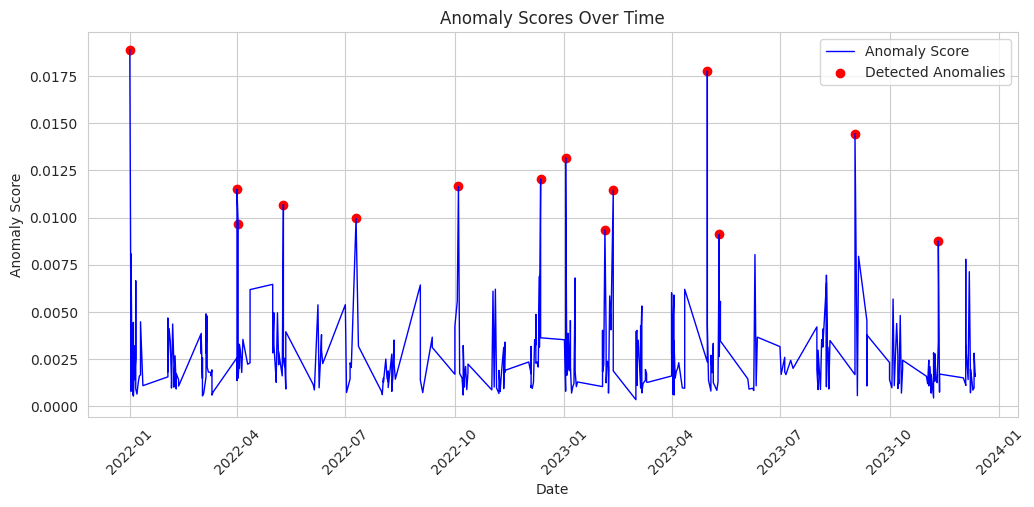

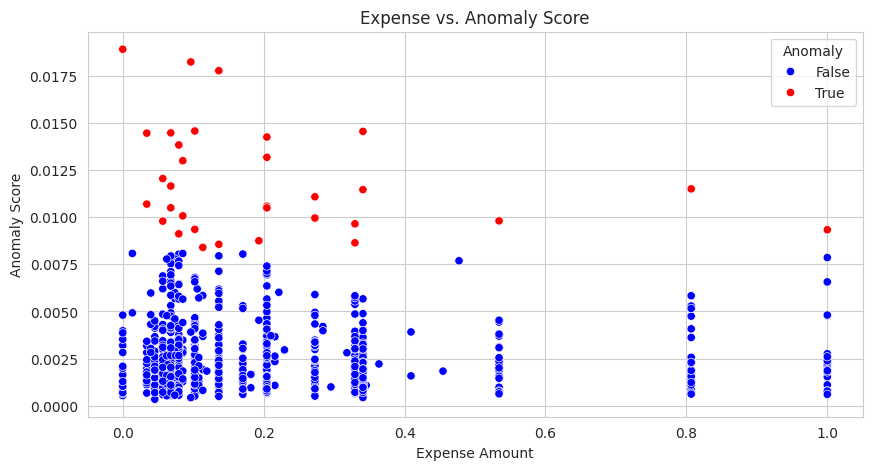

<ipython-input-7-f525902e9246>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df["Anomaly"] == True], x="Category", order=df["Category"].value_counts().index, palette="coolwarm")


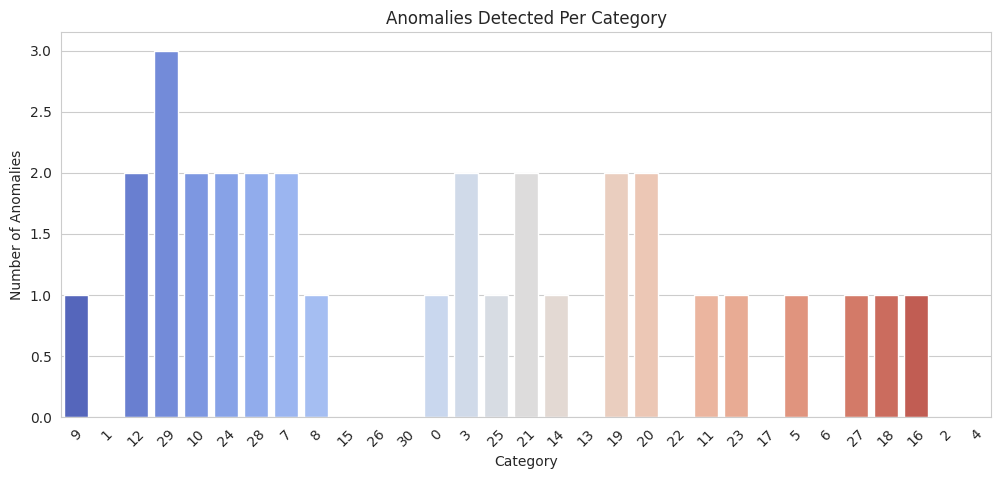

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load anomaly results
file_path = "/content/T-Diff_anomaly_results.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort by Date for time-series visualization
df = df.sort_values("Date")

# Set plot style
sns.set_style("whitegrid")

# ====== Plot 1: Anomaly Scores Over Time ======
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Anomaly Score"], label="Anomaly Score", color="blue", linewidth=1)
plt.scatter(df[df["Anomaly"] == True]["Date"], df[df["Anomaly"] == True]["Anomaly Score"],
            color="red", label="Detected Anomalies", marker="o")
plt.xlabel("Date")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# ====== Plot 2: Expense vs. Anomaly Score ======
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="Expense", y="Anomaly Score", hue="Anomaly", palette={True: "red", False: "blue"})
plt.xlabel("Expense Amount")
plt.ylabel("Anomaly Score")
plt.title("Expense vs. Anomaly Score")
plt.show()

# ====== Plot 3: Anomalies by Category ======
plt.figure(figsize=(12, 5))
sns.countplot(data=df[df["Anomaly"] == True], x="Category", order=df["Category"].value_counts().index, palette="coolwarm")
plt.xlabel("Category")
plt.ylabel("Number of Anomalies")
plt.title("Anomalies Detected Per Category")
plt.xticks(rotation=45)
plt.show()

